In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
# cwd = os.getcwd()
# cwd

In [3]:
# raw_csv_data = pd.read_csv(cwd + '\TG.csv')
raw_csv_data = pd.read_csv('KA.csv')
df=raw_csv_data.copy()

In [4]:
para = 'Deceased'

In [5]:
df.Date.describe()

count           115
unique          115
top       21-Apr-20
freq              1
Name: Date, dtype: object

In [6]:
df

,Date,Confirmed,Recovered,Deceased
0,14-Mar-20,6,0,1
1,15-Mar-20,0,0,0
2,16-Mar-20,1,0,0
3,17-Mar-20,2,0,0
4,18-Mar-20,5,0,0
...,...,...,...,...
110,02-Jul-20,1502,271,19
111,03-Jul-20,1694,471,21
112,04-Jul-20,1839,439,42
113,05-Jul-20,1925,603,37


In [7]:
df.Date = pd.to_datetime(df.Date)

In [8]:
df.head()

,Date,Confirmed,Recovered,Deceased
0,2020-03-14,6,0,1
1,2020-03-15,0,0,0
2,2020-03-16,1,0,0
3,2020-03-17,2,0,0
4,2020-03-18,5,0,0


In [9]:
df

,Date,Confirmed,Recovered,Deceased
0,2020-03-14,6,0,1
1,2020-03-15,0,0,0
2,2020-03-16,1,0,0
3,2020-03-17,2,0,0
4,2020-03-18,5,0,0
...,...,...,...,...
110,2020-07-02,1502,271,19
111,2020-07-03,1694,471,21
112,2020-07-04,1839,439,42
113,2020-07-05,1925,603,37


In [10]:
df.set_index('Date', inplace=True)
df.index.freq = 'D'

In [11]:
df

,Confirmed,Recovered,Deceased
Date,,,
2020-03-14,6,0,1
2020-03-15,0,0,0
2020-03-16,1,0,0
2020-03-17,2,0,0
2020-03-18,5,0,0
...,...,...,...
2020-07-02,1502,271,19
2020-07-03,1694,471,21
2020-07-04,1839,439,42


In [12]:
# df.Date.describe()

In [13]:
df

,Confirmed,Recovered,Deceased
Date,,,
2020-03-14,6,0,1
2020-03-15,0,0,0
2020-03-16,1,0,0
2020-03-17,2,0,0
2020-03-18,5,0,0
...,...,...,...
2020-07-02,1502,271,19
2020-07-03,1694,471,21
2020-07-04,1839,439,42


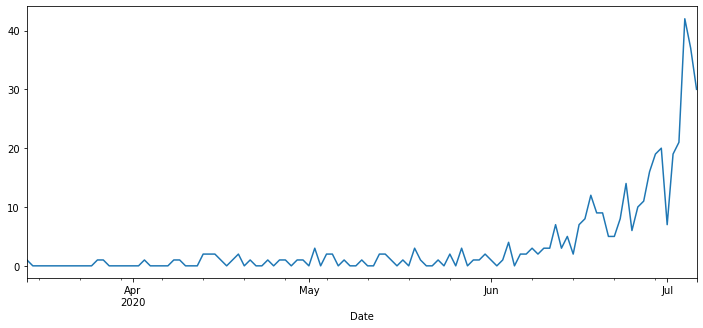

In [14]:
df[para].plot(figsize=(12,5));

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [16]:
adf_test(df[para])

Augmented Dickey-Fuller Test: 
ADF test statistic        5.234058
p-value                   1.000000
# lags used               9.000000
# observations          105.000000
critical value (1%)      -3.494220
critical value (5%)      -2.889485
critical value (10%)     -2.581676
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


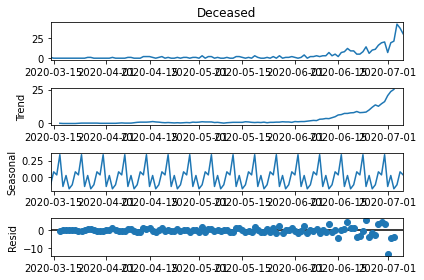

In [17]:
result = seasonal_decompose(df[para])
result.plot();

In [18]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df[para],k_diff=2)

In [19]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.976146
p-value                   0.297129
# lags used              12.000000
# observations          100.000000
critical value (1%)      -3.497501
critical value (5%)      -2.890906
critical value (10%)     -2.582435
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [20]:
# stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
#                           max_p=4, max_q=4,
#                           seasonal=False,
#                           d=None, trace=True,
#                           error_action='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings=True,  # we don't want convergence warnings
#                           stepwise=True)           # set to stepwise

# stepwise_fit.summary()

stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
                          max_p=4, max_q=4,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True,           # set to stepwise
                         frequency=10)

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=599.747, BIC=605.220, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=592.032, BIC=600.240, Time=0.037 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=590.083, BIC=598.291, Time=0.057 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=598.423, BIC=601.159, Time=0.015 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=581.774, BIC=592.719, Time=0.108 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=592.061, BIC=605.742, Time=0.100 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=592.110, BIC=605.791, Time=0.112 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=590.933, BIC=601.878, Time=0.055 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=594.031, BIC=604.976, Time=0.040 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=588.604, BIC=605.022, Time=0.277 seconds
Total fit time: 0.822 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -286.887
Date:                Wed, 15 Jul 2020   AIC                            581.774
Time:                        23:06:52   BIC                            592.719
Sample:                             0   HQIC                           586.216
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4785      0.706      0.678      0.498      -0.905       1.862
ar.L1         -0.9933      0.038    -26.351      0.000      -1.067      -0.919
ma.L1          0.9144      0.084     10.867      0.000       0.750       1.079
sigma2         8.8765      0.585     15.161      0.000       7.729      10.024
===================================================================================
Ljung-Box (Q):                       64.83   Jarque-Bera (JB):               909.63
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              41.83   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
train = df.iloc[:104]
test = df.iloc[104:111]

In [22]:
# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
# model = ARIMA(train[para],order=(1, 1, 1))
model = SARIMAX(train[para],order=(1, 1, 1),seasonal_order=(1,1,1,10))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Deceased   No. Observations:                  104
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 10)   Log Likelihood                -172.043
Date:                            Wed, 15 Jul 2020   AIC                            354.085
Time:                                    23:06:52   BIC                            366.748
Sample:                                03-14-2020   HQIC                           359.198
                                     - 06-25-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2043      0.145      1.405      0.160      -0.081       0.489
ma.L1         -0.7469      0.097     -7.696      0.000      -0.937      -0.557
ar.S.L10      -0.3878      0.191     -2.030      0.042      -0.762      -0.013
ma.S.L10      -0.3092      0.216     -1.432      0.152      -0.732       0.114
sigma2         2.2318      0.296      7.550      0.000       1.652       2.811
===================================================================================
Ljung-Box (Q):                       52.33   Jarque-Bera (JB):                18.76
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               9.41   Skew:                             0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Obtain predicted values
# start=len(train)
# end=len(train)+len(test)-1

start=104
end=110

# predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(1,1,1,10) Predictions')

# df['forecast'] = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')

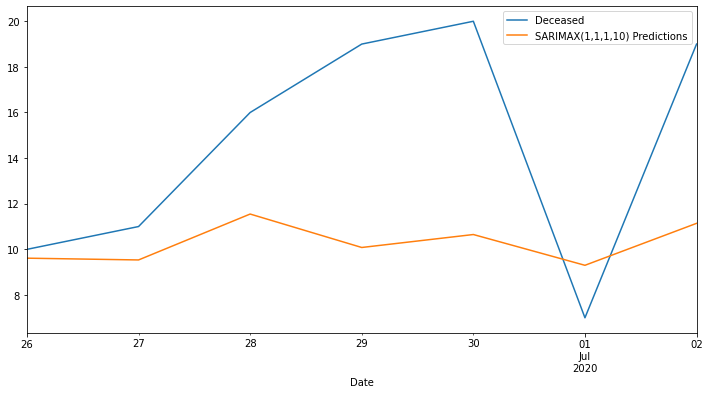

In [25]:
# Obtain predicted values
ax = test[para].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
# df['forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [26]:
# # from statsmodels.tools.eval_measures import rmse
# from statsmodels.tools.eval_measures import mse

# error = mse(test[para], predictions)
# # print(f'ARIMA(2,2,1) RMSE Error: {error:11.10}')
# # print(f'ARIMA(2,2,1) MSE Error: {error:11.10}')
# print(f'SARIMAX(2,2,1,3) MSE Error: {error:11.10}')

In [27]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(test[para], predictions)
MAE

4.961773125416804

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# per_MAPE = (MAPE/sum(test[para]))*100
per_MAPE = mean_absolute_percentage_error(test[para], predictions)
print(per_MAPE,'%')

30.419068026716683 %


In [29]:
type(predictions)

pandas.core.series.Series

In [30]:
df['forecast'] = predictions
df

,Confirmed,Recovered,Deceased,d1,forecast
Date,,,,,
2020-03-14,6,0,1,NaN,NaN
2020-03-15,0,0,0,NaN,NaN
2020-03-16,1,0,0,1.0,NaN
2020-03-17,2,0,0,0.0,NaN
2020-03-18,5,0,0,0.0,NaN
...,...,...,...,...,...
2020-07-02,1502,271,19,25.0,11.140198
2020-07-03,1694,471,21,-10.0,NaN
2020-07-04,1839,439,42,19.0,NaN


In [31]:
dictt = {f'{para}':test[para],f'Predicted_{para}':predictions}
dictt

{'Deceased': Date
 2020-06-26    10
 2020-06-27    11
 2020-06-28    16
 2020-06-29    19
 2020-06-30    20
 2020-07-01     7
 2020-07-02    19
 Freq: D, Name: Deceased, dtype: int64,
 'Predicted_Deceased': 2020-06-26     9.613105
 2020-06-27     9.535372
 2020-06-28    11.548055
 2020-06-29    10.081790
 2020-06-30    10.649924
 2020-07-01     9.300855
 2020-07-02    11.140198
 Freq: D, Name: SARIMAX(1,1,1,10) Predictions, dtype: float64}

In [32]:
predicted_df = pd.DataFrame(dictt)
predicted_df

,Deceased,Predicted_Deceased
Date,,
2020-06-26,10,9.613105
2020-06-27,11,9.535372
2020-06-28,16,11.548055
2020-06-29,19,10.081790
2020-06-30,20,10.649924
2020-07-01,7,9.300855
2020-07-02,19,11.140198


In [33]:
# predicted_df.to_csv('Predicted_KA.csv')
predicted_csv = pd.read_csv('Predicted_KA.csv')

predicted_csv.Date = pd.to_datetime(predicted_csv.Date)
predicted_csv.set_index('Date', inplace=True)
predicted_csv.index.freq = 'D'
# print(predicted_csv)
# predicted_csv = pd.concat([predicted_csv,predicted_df],axis=1,ignore_index=True)
predicted_csv = pd.merge(predicted_csv, predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(predicted_csv)
predicted_csv.to_csv('Predicted_KA.csv')

            Confirmed  Predicted_Confirmed  Recovered  Predicted_Recovered  \
Date                                                                         
2020-06-26        445           469.632977        246           327.789313   
2020-06-27        918           497.778592        371           387.083351   
2020-06-28       1267           589.269021        220           288.207135   
2020-06-29       1105           584.347884        176           329.915297   
2020-06-30        947           567.500862        235           415.154381   
2020-07-01       1272           578.514127        145           315.635634   
2020-07-02       1502           667.890520        271           384.148128   

            Deceased  Predicted_Deceased  
Date                                      
2020-06-26        10            9.613105  
2020-06-27        11            9.535372  
2020-06-28        16           11.548055  
2020-06-29        19           10.081790  
2020-06-30        20           10.64992

In [34]:
from pandas.tseries.offsets import DateOffset
import datetime
future_dates=[datetime.datetime(2020, 7, 7)+ DateOffset(n=x)for x in range(0,25)]

In [35]:
future_datest_df=pd.DataFrame(index=future_dates,columns=df.columns)

In [36]:
future_datest_df.tail()

,Confirmed,Recovered,Deceased,d1,forecast
2020-07-27,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN,NaN
2020-07-31,NaN,NaN,NaN,NaN,NaN


In [37]:
future_df=pd.concat([df,future_datest_df])
future_df = future_df.drop("d1", axis=1)
future_df

,Confirmed,Recovered,Deceased,forecast
2020-03-14,6,0,1,NaN
2020-03-15,0,0,0,NaN
2020-03-16,1,0,0,NaN
2020-03-17,2,0,0,NaN
2020-03-18,5,0,0,NaN
...,...,...,...,...
2020-07-27,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN


In [38]:
future_df[[para, 'forecast']]

,Deceased,forecast
2020-03-14,1,NaN
2020-03-15,0,NaN
2020-03-16,0,NaN
2020-03-17,0,NaN
2020-03-18,0,NaN
...,...,...
2020-07-27,NaN,NaN
2020-07-28,NaN,NaN
2020-07-29,NaN,NaN
2020-07-30,NaN,NaN


In [39]:
# future_df['forecast'] = results.predict(start = 115, end = 139, dynamic= True)
future_pred = results.predict(start=115, end=139, dynamic=False, typ='levels')

In [40]:
future_df['forecast'] = future_pred

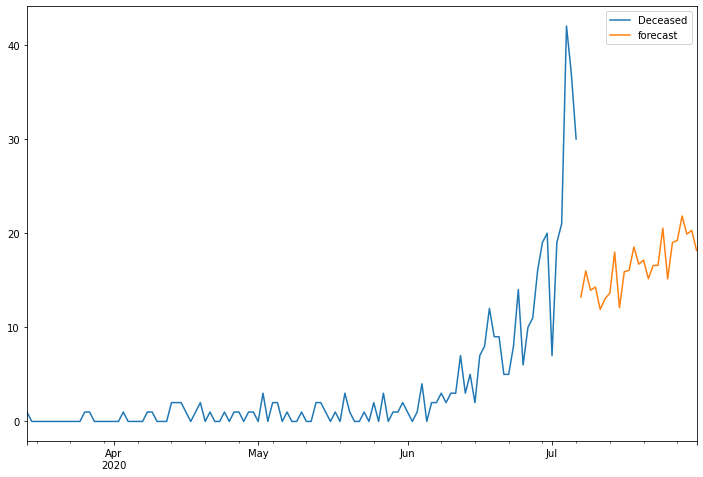

In [41]:
future_df[[para, 'forecast']].plot(figsize=(12, 8))

In [42]:
dicttt = {f'Future_Predicted_{para}':future_pred}
dicttt

{'Future_Predicted_Deceased': 2020-07-07    13.219007
 2020-07-08    15.994200
 2020-07-09    13.931532
 2020-07-10    14.279019
 2020-07-11    11.901916
 2020-07-12    13.027993
 2020-07-13    13.637974
 2020-07-14    17.987660
 2020-07-15    12.082397
 2020-07-16    15.905607
 2020-07-17    16.059393
 2020-07-18    18.538903
 2020-07-19    16.707505
 2020-07-20    17.140554
 2020-07-21    15.162097
 2020-07-22    16.564760
 2020-07-23    16.587727
 2020-07-24    20.532078
 2020-07-25    15.141305
 2020-07-26    19.016120
 2020-07-27    19.226769
 2020-07-28    21.820938
 2020-07-29    19.899859
 2020-07-30    20.299729
 2020-07-31    18.166687
 Freq: D, dtype: float64}

In [43]:
future_predicted_df = pd.DataFrame(dicttt)
future_predicted_df

,Future_Predicted_Deceased
2020-07-07,13.219007
2020-07-08,15.994200
2020-07-09,13.931532
2020-07-10,14.279019
2020-07-11,11.901916
2020-07-12,13.027993
2020-07-13,13.637974
2020-07-14,17.987660
2020-07-15,12.082397
2020-07-16,15.905607


In [44]:
# future_predicted_df.index.names = ['Date']
# future_predicted_df.index.freq = 'D'
# future_predicted_df.to_csv('Future_Predicted_KA.csv')

future_predicted_csv = pd.read_csv('Future_Predicted_KA.csv')

future_predicted_csv.Date = pd.to_datetime(future_predicted_csv.Date)
future_predicted_csv.set_index('Date', inplace=True)
future_predicted_csv.index.freq = 'D'
# print(future_predicted_csv)
# future_predicted_csv = pd.concat([future_predicted_csv,future_predicted_df],axis=1,ignore_index=True)
future_predicted_csv = pd.merge(future_predicted_csv, future_predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(future_predicted_csv)
future_predicted_csv.to_csv('Future_Predicted_KA.csv')

            Future_Predicted_Confirmed  Future_Predicted_Recovered  \
Date                                                                 
2020-07-07                  739.027417                  389.576605   
2020-07-08                  717.835258                  372.659690   
2020-07-09                  730.687805                  449.783558   
2020-07-10                  829.373149                  333.059020   
2020-07-11                  821.801753                  454.963942   
2020-07-12                  798.915769                  347.464758   
2020-07-13                  812.922049                  645.690044   
2020-07-14                  916.380750                  521.581081   
2020-07-15                  908.836255                  512.992680   
2020-07-16                  884.255914                  460.260097   
2020-07-17                  899.453195                  473.545954   
2020-07-18                 1007.720718                  553.168868   
2020-07-19          